In [559]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [560]:
images = [cv2.imread("../mire_1.png"), cv2.imread("../mire_2.png")]


Nous allons adopter les conventions suivantes : les axes x,y sont tels que x correspond à la coordonnée en ligne du pixel et y correspond à la coordonnée en colonne du pixel, ainsi Nx correspond au nombre de corners en "ordonnée", Ny correspond au nombre de coordonnées en "abscisse".

[[ 88.681854  42.74233 ]
 [137.12468   45.0167  ]
 [184.81654   47.87287 ]
 [231.97073   50.377857]
 [278.7067    52.10026 ]
 [324.89267   54.090847]
 [370.96216   55.846214]
 [416.6611    57.813137]
 [462.0089    59.522266]
 [507.49118   61.292118]
 [552.5713    62.609333]
 [ 84.32411   86.35369 ]
 [133.82164   89.069984]
 [182.25935   91.47693 ]
 [230.01208   93.93152 ]
 [277.22156   95.21159 ]
 [324.16678   97.34359 ]
 [370.74094   98.88648 ]
 [417.01324  100.573494]
 [462.87494  102.55206 ]
 [508.61972  104.291695]
 [554.5783   105.774635]
 [ 80.29915  131.46962 ]
 [130.34117  133.66515 ]
 [179.6634   136.17955 ]
 [227.83087  138.03224 ]
 [275.6406   139.87222 ]
 [323.40475  141.24475 ]
 [370.6696   142.40625 ]
 [417.56915  144.23119 ]
 [463.67853  146.3572  ]
 [510.2055   148.00198 ]
 [556.4678   149.49472 ]
 [ 76.11482  177.71082 ]
 [126.795265 180.18948 ]
 [176.58322  181.81247 ]
 [225.803    183.61215 ]
 [274.5514   185.21533 ]
 [322.5218   186.23082 ]
 [370.56863  187.9444  ]


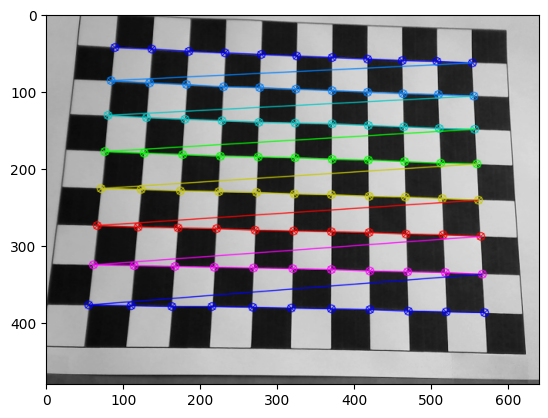

In [561]:
cnt = 1
ny = 11
nx = 8
coord_px = []
for image in images:
    ret, corners = cv2.findChessboardCorners(image, (ny, nx))
    result_name = '../data/board_corners_draw'+str(cnt)+'.jpg'
    corners_fliped = np.fliplr(np.flip(np.squeeze(corners)))
    coord_px.append(corners_fliped)
    cv2.drawChessboardCorners(image, (ny, nx), corners_fliped, ret)
    if cnt == 1:
        plt.imshow(image)
    cv2.imwrite(result_name, image)
    cnt += 1
print(coord_px[0])

coord_px = np.concatenate((coord_px[0], coord_px[1]))

In [562]:
ecart_corners_y = np.linspace(0, 20*nx - 20, nx)
ecart_corners_x = np.linspace(0, 20*ny - 20, ny)
ecart_corners_z_picture_1 = np.linspace(0, 0, ny)
ecart_corners_z_picture_2 = np.linspace(100, 100, ny)

xv, yv = np.meshgrid(ecart_corners_x, ecart_corners_y)
zv_1, yv = np.meshgrid(ecart_corners_z_picture_1, ecart_corners_y)
zv_2, yv = np.meshgrid(ecart_corners_z_picture_2, ecart_corners_y)

coord_mm = np.stack((xv, yv, zv_1), axis=2) # La coordonnée selon z est 0
coord_mm = np.concatenate((coord_mm, np.stack((xv, yv, zv_2), axis=2)), axis=0)
coord_mm = coord_mm.reshape(176, 3)
print(coord_mm)

[[  0.   0.   0.]
 [ 20.   0.   0.]
 [ 40.   0.   0.]
 [ 60.   0.   0.]
 [ 80.   0.   0.]
 [100.   0.   0.]
 [120.   0.   0.]
 [140.   0.   0.]
 [160.   0.   0.]
 [180.   0.   0.]
 [200.   0.   0.]
 [  0.  20.   0.]
 [ 20.  20.   0.]
 [ 40.  20.   0.]
 [ 60.  20.   0.]
 [ 80.  20.   0.]
 [100.  20.   0.]
 [120.  20.   0.]
 [140.  20.   0.]
 [160.  20.   0.]
 [180.  20.   0.]
 [200.  20.   0.]
 [  0.  40.   0.]
 [ 20.  40.   0.]
 [ 40.  40.   0.]
 [ 60.  40.   0.]
 [ 80.  40.   0.]
 [100.  40.   0.]
 [120.  40.   0.]
 [140.  40.   0.]
 [160.  40.   0.]
 [180.  40.   0.]
 [200.  40.   0.]
 [  0.  60.   0.]
 [ 20.  60.   0.]
 [ 40.  60.   0.]
 [ 60.  60.   0.]
 [ 80.  60.   0.]
 [100.  60.   0.]
 [120.  60.   0.]
 [140.  60.   0.]
 [160.  60.   0.]
 [180.  60.   0.]
 [200.  60.   0.]
 [  0.  80.   0.]
 [ 20.  80.   0.]
 [ 40.  80.   0.]
 [ 60.  80.   0.]
 [ 80.  80.   0.]
 [100.  80.   0.]
 [120.  80.   0.]
 [140.  80.   0.]
 [160.  80.   0.]
 [180.  80.   0.]
 [200.  80.   0.]
 [  0. 100

D'après le site du constructeur de webcam logitech, la référence C270 a une distance focale de 4.0 mm.

In [563]:
f = 4

In [564]:
i2, i1 = images[0].shape[0]/2, images[0].shape[1]/2
print(i1)
print(i2)

320.0
240.0


In [565]:
u_1_tilde = coord_px[:,0] - i1 # x 
u_2_tilde = coord_px[:,1] - i2 # y

In [566]:
lignes = 176

In [567]:
A = np.zeros((lignes, 7))
U1 = u_1_tilde

In [568]:
for i in range(lignes):
    A[i] = np.array([u_2_tilde[i]*coord_mm[i,0], u_2_tilde[i]*coord_mm[i,1], u_2_tilde[i]*coord_mm[i,2], u_2_tilde[i], 
                     -u_1_tilde[i]*coord_mm[i,0], -u_1_tilde[i]*coord_mm[i,1], -u_1_tilde[i]*coord_mm[i,2]])
print(A)

[[    -0.             -0.             -0.         ...      0.
       0.              0.        ]
 [ -3899.6661377      -0.             -0.         ...   3657.50640869
       0.              0.        ]
 [ -7685.08544922     -0.             -0.         ...   5407.33825684
       0.              0.        ]
 ...
 [ 23596.00585938  20646.50512695  14747.50366211 ... -15298.04199219
  -13385.78674316  -9561.27624512]
 [ 26644.54833984  20723.53759766  14802.52685547 ... -24106.7010498
  -18749.65637207 -13392.61169434]
 [ 29827.71606445  20879.40124512  14913.85803223 ... -34154.56542969
  -23908.19580078 -17077.28271484]]


In [569]:
L = np.linalg.inv(A.T @ A) @ A.T @ U1

Calcul des paramètres de L :

In [570]:
o_2_c_abs = 1/(np.sqrt(L[4]**2+L[5]**2+L[6]**2))
o_2_c = - o_2_c_abs
beta = o_2_c_abs * np.sqrt(L[0]**2+L[1]**2+L[2]**2)
o_1_c = L[3] * o_2_c / beta
r11 = L[0] * o_2_c / beta
r12 = L[1] * o_2_c / beta
r13 = L[2] * o_2_c / beta
r21 = L[4] * o_2_c
r22 = L[5] * o_2_c
r23 = L[6] * o_2_c


Déduction des paramètres de la matrice de rotation de la matrice extrinsèque : 

In [571]:
R1 = np.array([r11, r12, r13])
R2 = np.array([r21, r22, r23])
R3 = np.cross(R1, R2)
r31, r32, r33 = R3[0], R3[1], R3[2]

Calcul des angles de rotation entre l'espace monde et l'espace caméra :

In [572]:
phi = - np.arctan(r23/r33)
gamma = - np.arctan(r12/r11)
omega = np.arctan(r13/(-r23*np.sin(phi)+r33*np.cos(phi)))
print(np.rad2deg(phi))
print(np.rad2deg(gamma))
print(np.rad2deg(omega))

-10.904188643693375
1.1146316578153945
-5.524758343104423


In [573]:
B = np.zeros((lignes, 2))
R = np.zeros((lignes, 1))
for i in range(lignes):
    R[i] = -u_2_tilde[i] * (r31*coord_mm[i, 0]+r32*coord_mm[i, 1]+r33*coord_mm[i, 2])
    B[i] = np.array([u_2_tilde[i], -(r21*coord_mm[i, 0] + r22*coord_mm[i, 1] + r23*coord_mm[i, 2] + o_2_c)])

In [574]:
F = np.squeeze(np.linalg.pinv(B.T @ B) @ B.T @ R)
o_3_c = F[0]
f2 = F[1]
print(f2)

805.5258636114684


In [575]:
print(o_1_c)
print(o_2_c)
print(o_3_c)

-97.53458853587493
-84.63248760021786
340.091081081713


In [576]:
s2 = f/f2
s1 = s2 / beta
print(s1)
print(s2)

0.004896227458157459
0.004965700271952201


In [577]:
M_int = np.array(
    [[f/s1, 0, i1, 0],
     [0, f/s2, i2, 0],
     [0, 0, 1, 0]]
)
M_ext = np.array(
    [[r11, r12, r13, o_1_c],
     [r21, r22, r23, o_2_c],
     [r31, r32, r33, o_3_c],
     [0, 0, 0, 1]]
)
M = M_int @ M_ext

Nous avons donc calculé M, la matrice de transformation qui permet le changement de repère : repère objet à l'espace image pixellisé. Il faut donc vérifier la cohérence de  nos calculs. Pour cela nous allons réutiliser les points de l'espace objet de la variable coord_mm. Les 88 premiers points correspondant aux 88 coordonnées de l'image "mire_1", seront multiplié à la matrice M. La relation suivante montre les résultat de la matrice de gauche attendu: u1 et u2 correspondent aux coordonnées dans l'espace image en pixel de l'image. Ainsi il faut normalisé par alpha la valeur obtenu en sortie du produit M par coord_mm pour obtenir les réelles valeurs en pixel.

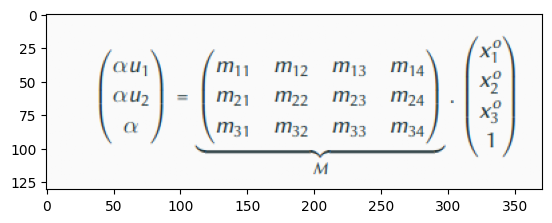

In [578]:
im = plt.imread("../data/relation_pixel_objet.png")
plt.imshow(im)
plt.show()

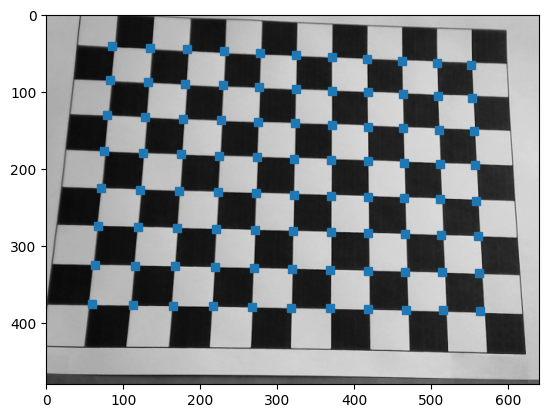

In [579]:
im = plt.imread("../mire_1.png")
fig, ax = plt.subplots()
U = np.ndarray((88,1))
V = np.ndarray((88,1))
for i in range(int(lignes/2)):
    alpha_U = M @ np.append(coord_mm[i, :], 1)
    alpha = alpha_U[2]
    U[i] = alpha_U[0] / alpha
    V[i] = alpha_U[1] / alpha

U = np.squeeze(U)
V = np.squeeze(V)
plt.plot(U, V, 's')
plt.imshow(im)
plt.show()

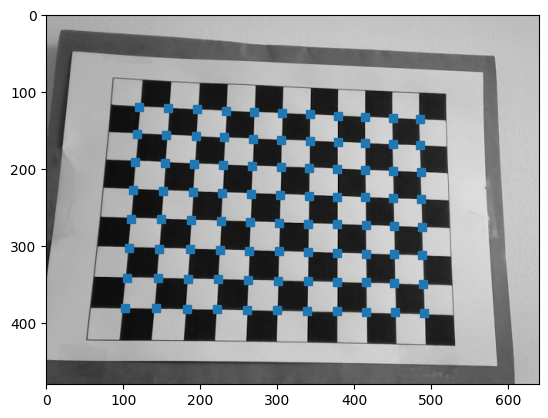

In [580]:
im = plt.imread("../mire_2.png")
fig, ax = plt.subplots()
U = np.ndarray((88,1))
V = np.ndarray((88,1))
for i in range(int(lignes/2), lignes):
    alpha_U = M @ np.append(coord_mm[i, :], 1)
    alpha = alpha_U[2]
    U[i-int(lignes/2)] = alpha_U[0] / alpha
    V[i-int(lignes/2)] = alpha_U[1] / alpha

U = np.squeeze(U)
V = np.squeeze(V)
plt.plot(U, V, 's')
plt.imshow(im)
plt.show()